# Reproducing a Paper - Softconsensus

In this section, we will reproduce the functionality described in  [[von Löhneysen et al. - 2023]](https://journals.sagepub.com/doi/pdf/10.1089/cmb.2024.0519). Below is a brief introduction to the key concepts required for this task. For further details, please refer to the original paper.

## Introduction 
As discussed in the first part, covariation information from a multiple sequence alignment can improve the folding of the alignment. This is done by **RNAalifold**, which outputs a consensus structure for the alignment. However, the consensus structure cannot always be directly applied to individual sequences. To address this, we will implement a pipeline to construct a secondary structure for an individual sequence of the alignment, which we will name focal sequence from now on.

### Strategy I: Hard Constraints from the Consensus Structure

In this strategy, we will extract all valid base pairs from the consensus structure generated by RNAalifold and use them as hard constraints to refold the focal sequence. In order to filter out nonsensical interactions, the consensus structure must first be modified by:

1. Removing all base pairs with non-compatible nucleotides in the focal sequence.  
2. Removing all base pairs where one interaction partner maps to a gap position in the focal sequence.  
3. Removing all hairpins with a length less than 3.  

This approach ensures that the constraints are valid in the context of the focal sequence while adopting as many interactions from the consensus structure as possible.

### Strategy II: Base Pair Probability and Soft Constraints

Here, we will leverage base pair probabilities and soft constraints to refine the folding process. This is achieved by assigning a bonus energy to each valid base pair in the consensus structure. This bonus energy of an interaction is selected to be proportional to its base pairing probability within the ensemble.

More specifically, the bonus energy for a feature $\gamma$ (such as a base pair) is calculated as the difference between the free energies of the ensemble with and without the feature $\gamma$. This approach allows us to incorporate probabilistic information from the ensemble into the folding process, providing a more nuanced and flexible folding improvement compared to hard constraints.

In [ ]:
#Installing all requirements using conda. This method is recommended if you want to follow this tutorial on your own machine. If you have already created a conda environment for the first Notebook, you can use that.
!conda create --yes --name ViennaRNA-Tutorial python=3.14
!conda activate ViennaRNA-Tutorial
!conda install --yes bioconda::viennarna
!conda install --yes matplotlib
!conda install --yes numpy
!conda install --yes ipykernel
!conda install --yes cairosvg

In [ ]:
#Run this cell to set up the requirements on Google Colab. Don't run it on your local machine!
#Furthermore, you need to create a folder called 2_input in the Colab Working Directory (at /content/2_input) and upload the given files.
!pip install ViennaRNA
!apt-get update -qq
!apt-get install -y vienna-rna
!pip install cairosvg

Here are a few helper functions that will be used throughout the tutorial. Simply run the next four cells to load them into your environment.

In [2]:
import os
import re

import RNA
import numpy as np
from IPython.display import Image, HTML, display
import cairosvg


# The path to the provided alignment file
alignment_path = "2_input/alignment.fa"

# The reference structure of the focal sequence we want to reproduce
focal_seq_reference_ss = "((((((((((.....((((((((....(((((((.............))))..)))...)))))).)).((.((....((((((((...))))))))....)).))...))))))))))."


In [3]:
def plot_structures(ss):    
    """This functions plots an RNA structure and displays it next to the focal_seq_reference_ss.

    Args:
        ss (str): The secondary structure to display as a dot bracket string.
    """
    
    i = 1
    while os.path.exists(f"2_input/result_plot{i}.svg"):
        i += 1

    reference_path = "2_input/reference_plot.svg"
    result_path = f"2_input/result_plot{i}.svg"

    RNA.svg_rna_plot(' '*len(focal_seq_reference_ss), focal_seq_reference_ss, reference_path)
    RNA.svg_rna_plot(' '*len(ss), ss, result_path)

    cairosvg.svg2png(url=reference_path, write_to=reference_path.replace(".svg", ".png"))
    cairosvg.svg2png(url=result_path, write_to=result_path.replace(".svg", ".png"))

    print("Reference:")
    display(Image(filename=reference_path.replace(".svg", ".png")))
    print("Result:")
    display(Image(filename=result_path.replace(".svg", ".png")))



In [5]:
def read_alignment(path):
    """Reads the alignment file in fasta format and returns a list containing all sequences.

    Args:
        path (str): Path to the alignment in fasta format

    Returns:
        list: A list containing all sequences of the alignment
    """

    aligned_seq = []
    with open(path, 'r') as inF:
        for line in inF:
            if line.startswith('>'):
                continue
            aligned_seq.append(line.strip().upper().replace('T', 'U'))
    return aligned_seq

The next cell defines all the input variables required for the task. These include:

- **aligned_seq**: A list of all aligned sequences, including gap characters.  
- **seq**: A list of all aligned sequences without gap characters. The lengths of these sequences vary due to the removal of gaps.  
- **focal_seq**: The focal sequence (In this case simply the first sequence in the alignment). The primary goal is to predict the secondary structure of this sequence using information from the alignment. This sequence does not contain gap characters.  
- **aligned_focal_seq**: The focal sequence as it appears in the alignment, including gap characters.  
- **compatible_bases**: A list of all combinations of bases that can form canonical base pairs.

In [6]:
aligned_seq = read_alignment(alignment_path)
seq = [s.replace('-', '') for s in aligned_seq]
focal_seq = seq[0]
aligned_focal_seq = aligned_seq[0]
compatible_bases = ["AU", "UA", "CG", "GC", "UG", "GU"]

## MFE folding

Now it's your turn: Perform a basic sanity check by folding the focal sequence using the standard MFE algorithm without integrating the additional information from the alignment.  Use the function `plot_structures(ss)` to compare the resulting structure to the ground truth by visualizing them.

UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAACUCAGAAGUGAAACGCCGUAGCGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGGAACUGCCAGGCAU
Reference:


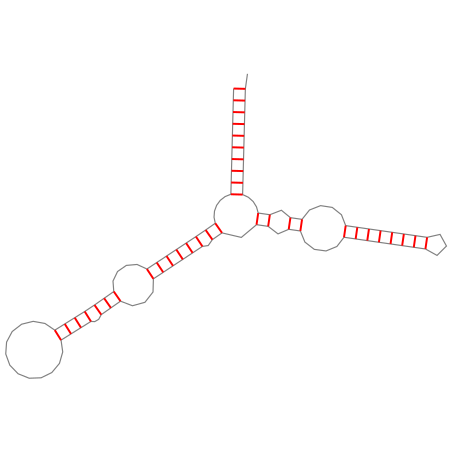

Result:


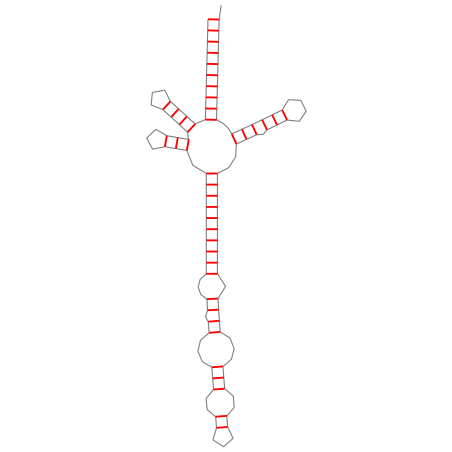

In [7]:
fc = RNA.fold_compound(focal_seq)
ss, mfe = fc.mfe()
print(focal_seq)
plot_structures(ss)

## Strategy I implementation (hard constraint)
Next, we aim to improve the result using *Strategy I*, as described above. Start by computing the consensus structure of the alignment stored in `aligned_seq`. Create a fold compound using the alignment and then calculate the MFE consensus structure.

In [8]:
fc_aln = RNA.fold_compound(aligned_seq)

consensus_ss, consensus_mfe = fc_aln.mfe()

The resulting secondary structure incorporates information from all sequences in the alignment, making it a more reliable prediction. However, it may not be fully compatible with the single focal sequence we aim to fold.

To address this, we will remove all interactions in the consensus structure that are incompatible with the focal sequence. Specifically, we will delete interactions that:

- Form non-canonical base pairs
- Include a gap character in the base pair
- Create hairpins with a length < 3

Save the cleaned secondary structure in dot bracket notation.

*Hint: Use `aligned_focal_seq` and the consensus structure you computed earlier, which should have the same length. Representing the structure as a pair table can simplify the removal of non-canonical pairs and interactions with gap characters. However, keep in mind that a pair table is 1-indexed (the 0th element stores the structure length), while the sequence is 0-indexed.*

*For the fixed hairpin length cutoff of 3, simple string replacement will suffice.*

In [9]:
consensus_ss_pt = RNA.ptable(consensus_ss)
clean_ss = ""
print(f"{aligned_focal_seq}\n{consensus_ss}\n\n")

#Step1: remove all gap positions and non-canonical interactions
for nuc, ss_idx in zip(aligned_focal_seq, range(1, consensus_ss_pt[0]+1)):
    if nuc == '-':
        if consensus_ss_pt[ss_idx] > 0:
            consensus_ss_pt[consensus_ss_pt[ss_idx]] = 0
        continue
    if consensus_ss_pt[ss_idx] == 0:
        clean_ss += '.'
    elif consensus_ss_pt[ss_idx] > ss_idx:
        if f"{nuc}{aligned_focal_seq[consensus_ss_pt[ss_idx]-1]}" not in compatible_bases:
            print(f"{nuc}{aligned_focal_seq[consensus_ss_pt[ss_idx]-1]}")
            consensus_ss_pt[consensus_ss_pt[ss_idx]] = 0
            clean_ss += '.'
        else:
            clean_ss += '('
    elif consensus_ss_pt[ss_idx] < ss_idx:
        clean_ss += ')'

#Step2: remove hairpins of length < 3
clean_ss.replace("()", "..").replace("(.)", "...").replace("(..)", "....")

print(f"{focal_seq}\n{clean_ss}\n\n")

UGCCUGGCGG-CCGUAGCGCG-G-UGGUCCC-AC-CUGACCCCAUGCCGAACUCA-GA-AGUGAAACGCCGUA-GC-G--CCGAUG----GUAGUGUG--GGGUCUCCCCAUGCGAG--AGUA-GG-G-AA-CUGCCAGGCAU
..((((((((.(....(((((.(.((.........((((.............))).).........))))))..)).(..((.((........(((((..((....)).)))))......))..)).)..).))))))))...


CA
GG
UGCCUGGCGGCCGUAGCGCGGUGGUCCCACCUGACCCCAUGCCGAACUCAGAAGUGAAACGCCGUAGCGCCGAUGGUAGUGUGGGGUCUCCCCAUGCGAGAGUAGGGAACUGCCAGGCAU
..((((((((.....((((((((.......((((.............))))........)))))).)).((.((....(((((((....)).)))))....)).))...))))))))...




When you have cleaned the secondary structure, use it as a hard constraint to fold the focal sequence. Visualize the results using the `plot_structures(ss)` function provided earlier.

*Hint: Use the `fc.constraints_add()` function to apply the constraints. Experiment with different flags to weakly or strongly enforce the constraints and observe if the results change.*

*You can also weaken the constraints by not enforcing the exact base pairs but instead just forcing the bases to form any interaction. In the pseudo dot bracket notation used in the ViennaRNA Package, this type of constraint is represented by the character `|`*

..((((((((.....((((((((.......((((.............))))........)))))).)).((.((....(((((((....)).)))))....)).))...))))))))... (constraint)
((((((((((.....((((((((....(((((((.............))))..)))...)))))).)).((.((....(((((((....)).)))))....)).))...)))))))))). (MFE)
((((((((((.....((((((((....(((((((.............))))..)))...)))))).)).((.((....((((((((...))))))))....)).))...)))))))))). (target)
Reference:


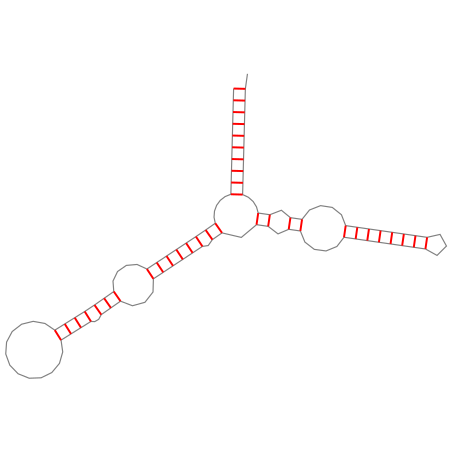

Result:


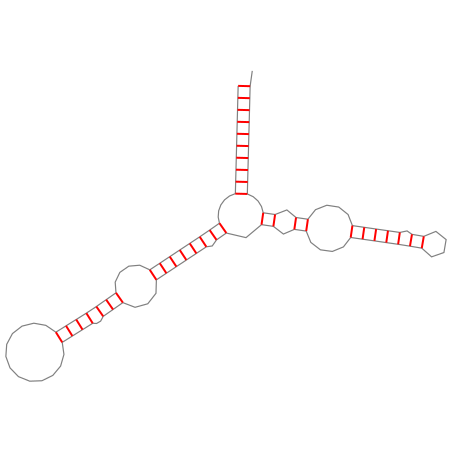

In [10]:
fc = RNA.fold_compound(focal_seq)
fc.constraints_add(clean_ss, RNA.CONSTRAINT_DB_DEFAULT)
#fc.constraints_add(clean_ss, RNA.CONSTRAINT_DB_DEFAULT|RNA.CONSTRAINT_DB_ENFORCE_BP)

ss, mfe = fc.mfe()
print(clean_ss, "(constraint)")
print(ss, "(MFE)")
print(focal_seq_reference_ss, "(target)")

plot_structures(ss)

The first strategy resulted in a significant improvement compared to the naive MFE prediction of the focal sequence without alignment information. However, this approach is somewhat heavy handed and does not produce a perfect match with the ground truth.

## Strategy II implementation (soft constraint)

To refine the results further, we will implement **Strategy II**, which introduces a bonus energy as a soft constraint for each interaction. This bonus energy is proportional to the free energy difference in the ensemble with and without the interaction.

First, calculate the base pair probability matrix of the ensemble. To do this, create a fold compound for the entire alignment and compute the probabilities from it.

In [11]:
fc_aln = RNA.fold_compound(aligned_seq)
css, cen = fc_aln.mfe()
fc_aln.exp_params_rescale(cen)
fc_aln.pf()

bpp_matrix = np.array(fc_aln.bpp())

Similar to **Strategy I**, we now select all interactions that are compatible with the focal sequence and have a probability above a defined threshold. Unlike before, we can skip removing interactions which lead to hairpins of length < 3, as their energy penalty in the thermodynamic model is sufficient to outweigh any bonus energy we might assign.

For this step, identify all interactions from the base pair probability matrix that:
- Have a non-zero probability in the ensemble (you can define and experiment with a custom cutoff)
- Do not involve gap characters in the focal sequence
- Are formed by compatible nucleotides in the focal sequence

To simplify the use of these results, store all valid interactions in an array. Each entry should include the indices of the two interacting partners and the corresponding base pair probability, e.g. `[[(4, 139), 0.997], ...]`

*Hint: The base pair probability matrix is a square matrix, with non-zero elements only in its upper triangular part.
You can also use the `plist` of the ViennaRNA-Package which  offers a very similar data structure. The function `plist_from_probs(cutoff)`, which is a member of `fold_compound`, can be called to create a plist which contains all basepairs with a probability above a given cutoff.*

In [12]:
cutoff = 0.1
interactions = [x for x in fc_aln.plist_from_probs(cutoff) if f"{aligned_focal_seq[x.i]}{aligned_focal_seq[x.j]}" in compatible_bases]
print(interactions)

[RNA.RNA.ep(i=4, j=139, p=0.99674, t=0), RNA.RNA.ep(i=8, j=135, p=0.999888, t=0), RNA.RNA.ep(i=18, j=75, p=0.979203, t=0), RNA.RNA.ep(i=20, j=71, p=0.99995, t=0), RNA.RNA.ep(i=25, j=68, p=0.999899, t=0), RNA.RNA.ep(i=33, j=62, p=0.373212, t=0), RNA.RNA.ep(i=36, j=57, p=0.987608, t=0), RNA.RNA.ep(i=84, j=122, p=0.935901, t=0), RNA.RNA.ep(i=85, j=121, p=0.921795, t=0), RNA.RNA.ep(i=94, j=114, p=0.996822, t=0), RNA.RNA.ep(i=95, j=113, p=0.995923, t=0), RNA.RNA.ep(i=96, j=112, p=0.997348, t=0), RNA.RNA.ep(i=97, j=111, p=0.999789, t=0), RNA.RNA.ep(i=101, j=108, p=0.987484, t=0), RNA.RNA.ep(i=102, j=107, p=0.988643, t=0)]


In this step, we calculate the bonus energy for the soft constraints associated with each interaction.

To compute the bonus energy for an interaction, calculate the ensemble free energy under two separate conditions:
1. **Enforce the interaction**: Add a hard constraint to ensure the interaction is formed.
2. **Forbid the interaction**: Add a hard constraint to prevent exactly this interaction from forming.

The bonus energy for each interaction is then defined as the difference between the two ensemble free energies calculated above. Update each entry in the array of interactions by appending the corresponding bonus energy.

*Hint: Use the `fc.hc_add_bp()` function to add hard constraints, along with the flags `RNA.CONSTRAINT_CONTEXT_ALL_LOOPS`, `RNA.CONSTRAINT_CONTEXT_ENFORCE`, and `RNA.CONSTRAINT_CONTEXT_NO_REMOVE`.*

*You can either use two separate fold compounds for the two conditions or reset the constraints by calling `fc.hc_init()` after each calculation.*

In [13]:
fc = RNA.fold_compound(aligned_seq)

for interaction in interactions:

    fc.hc_init()
    fc.hc_add_bp(interaction.i, interaction.j, RNA.CONSTRAINT_CONTEXT_ALL_LOOPS | RNA.CONSTRAINT_CONTEXT_ENFORCE)
    _, ener_w = fc.pf()

    fc.hc_init()
    fc.hc_add_bp(interaction.i, interaction.j, RNA.CONSTRAINT_CONTEXT_NO_REMOVE)
    _, ener_wo = fc.pf()

    # Overwrite the base pair probability by energy
    interaction.p = ener_w-ener_wo

print(interactions)

[RNA.RNA.ep(i=4, j=139, p=-3.52698, t=0), RNA.RNA.ep(i=8, j=135, p=-5.60447, t=0), RNA.RNA.ep(i=18, j=75, p=-2.37402, t=0), RNA.RNA.ep(i=20, j=71, p=-6.0991, t=0), RNA.RNA.ep(i=25, j=68, p=-5.67049, t=0), RNA.RNA.ep(i=33, j=62, p=0.319538, t=0), RNA.RNA.ep(i=36, j=57, p=-2.69838, t=0), RNA.RNA.ep(i=84, j=122, p=-1.6524, t=0), RNA.RNA.ep(i=85, j=121, p=-1.52045, t=0), RNA.RNA.ep(i=94, j=114, p=-3.54275, t=0), RNA.RNA.ep(i=95, j=113, p=-3.38879, t=0), RNA.RNA.ep(i=96, j=112, p=-3.65455, t=0), RNA.RNA.ep(i=97, j=111, p=-5.21542, t=0), RNA.RNA.ep(i=101, j=108, p=-2.69219, t=0), RNA.RNA.ep(i=102, j=107, p=-2.75278, t=0)]


Finally, create a fold compound using only the focal sequence and add the soft constraints based on the bonus energies calculated earlier. Assign the bonus energy to each interaction and determine the MFE structure. Use the `plot_structures(ss)` function to visualize the result compared to the ground truth structure.

*Hint: Pay attention to the indices! The focal sequence used for folding does not include gap characters, whereas the base pair probability matrix uses indices from the alignment, which includes gap characters. Ensure proper mapping between the two.*

Reference:


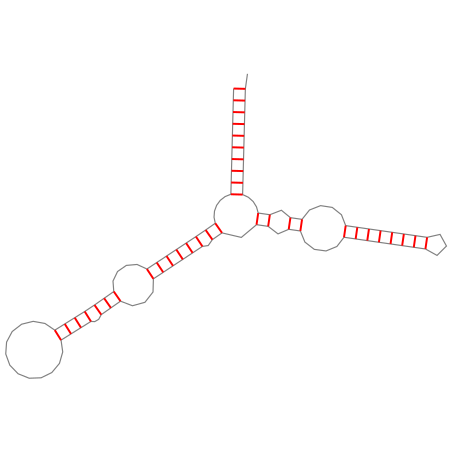

Result:


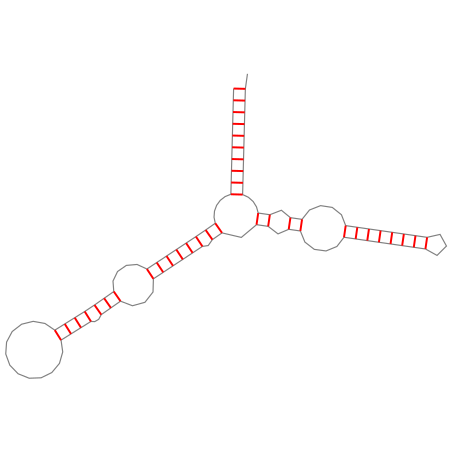

In [14]:
fc = RNA.fold_compound(focal_seq)

for interaction in interactions:
    pos1 = interaction.i - aligned_focal_seq[:interaction.i].count('-')
    pos2 = interaction.j - aligned_focal_seq[:interaction.j].count('-')

    fc.sc_add_bp(pos1, pos2, interaction.p)

ss, mfe = fc.mfe()

plot_structures(ss)